### **Import modules**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### **Load data**

In [2]:
df = pd.read_csv('boston.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [4]:
df.shape

(506, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [6]:
# check for missing values
df.isnull().sum() # no missing values

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### **Data exploration**

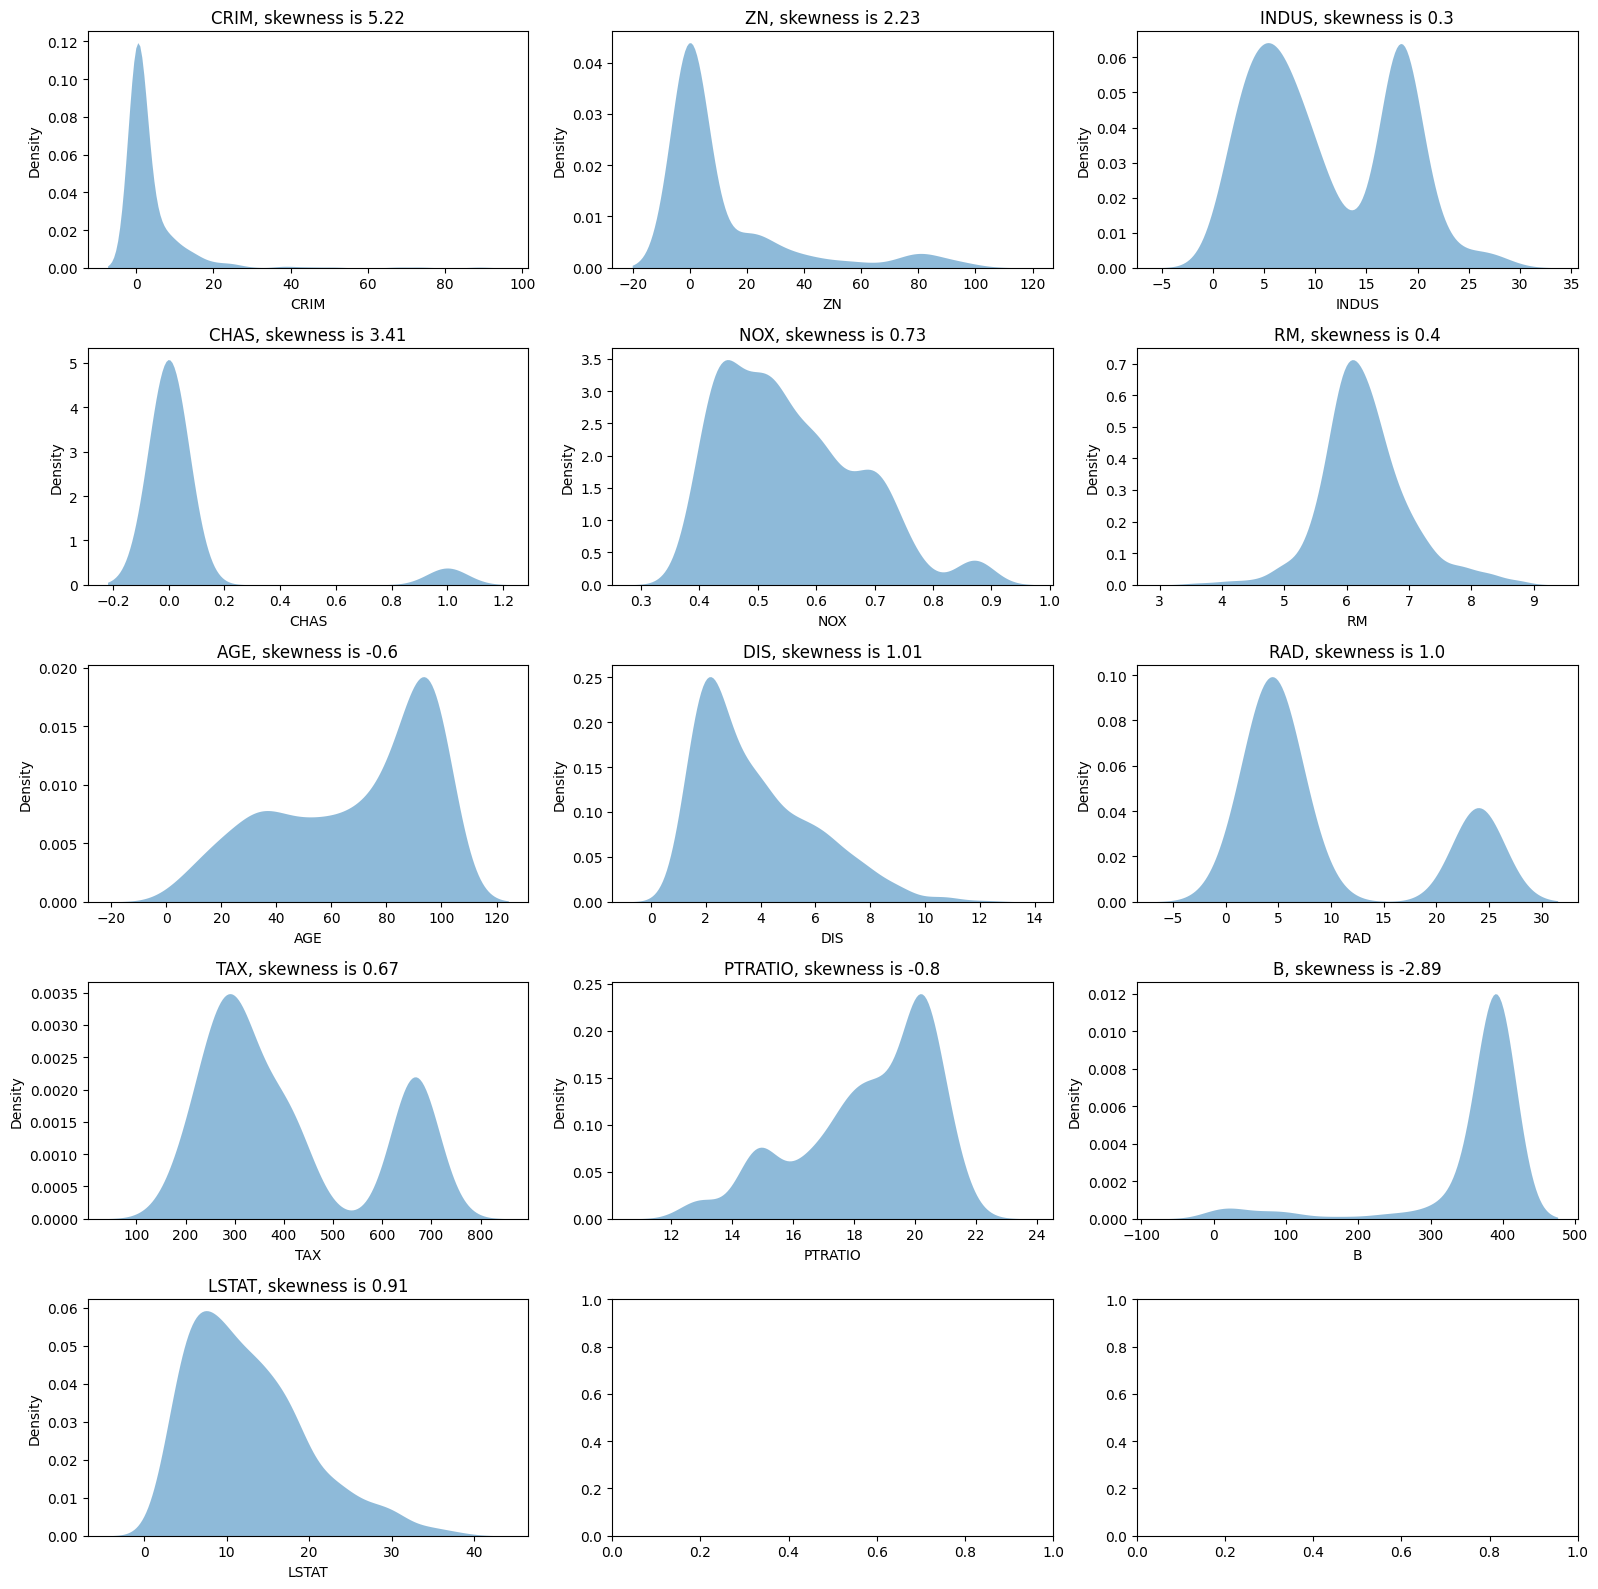

In [7]:
# Visualize distribution of each feature
fig, axs = plt.subplots(5, 3, figsize=(16,16))
axs = axs.flatten()
for i, data in enumerate(df.columns[:-1]):
    sns.kdeplot(df[data], ax=axs[i], fill=True,  alpha=.5, linewidth=0)
    axs[i].set_title(data + ', skewness is '+ str(round(df[data].skew(axis = 0, skipna = True),2)))
plt.tight_layout()

### **Preprocessing Data**

In [8]:
df_cleaned = df.copy()

In [9]:
# Define a function that detect and remove outliers
def outlier_detect(data):
    for column in data.columns[:-1]:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3-q1
        lower_bound = q1-(1.5*iqr)
        upper_bound = q3+(1.5*iqr)
        data_cleaned = data.loc[(data[column] > lower_bound) & (data[column] < upper_bound)]
    print('Number of outliers removed: ', len(data) - len(data_cleaned))
    return data_cleaned
    
df_cleaned = outlier_detect(df)

Number of outliers removed:  7


In [10]:
df_cleaned.shape

(499, 14)

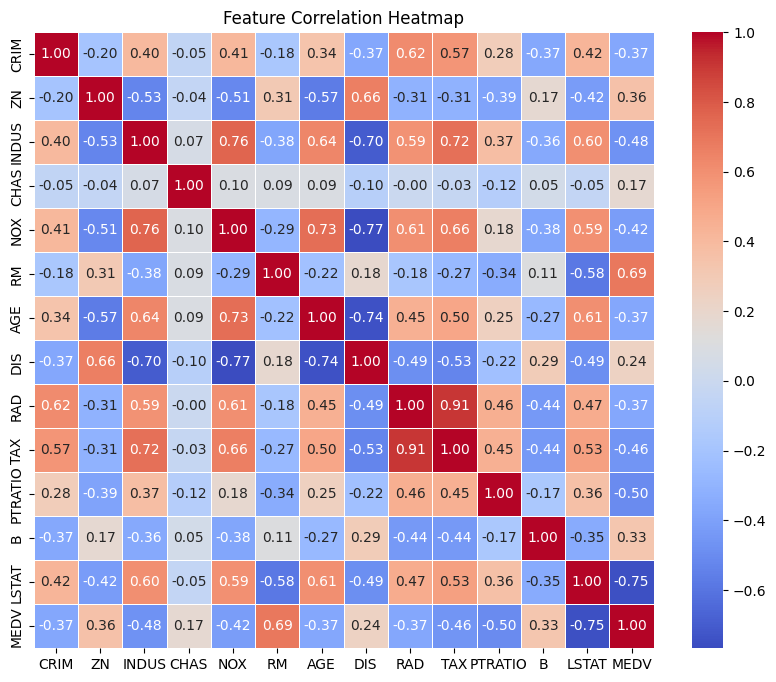

In [11]:
# Determine correlation between features and target
corr_matrix = df_cleaned.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

All features have absolute correlation less than 0.8. 

In [84]:
# Separate features and target variable
X = df_cleaned.drop('MEDV', axis=1)
Y = df_cleaned['MEDV']

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
# Splitting train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

### **Training models**

In [114]:
# Import models and evaluation metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [128]:
# Set up regression evaluation metrics
def evaluate(model_name, Y_test, Y_pred):
    rmse_score = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)
    adjusted_r2_score = 1 - (1-r2)*(len(X_test)-1)/(len(X_test)-X_test.shape[1]-1)
    
    result_df = pd.DataFrame({'Model': model_name, 
                         'RMSE': rmse_score, 
                         'R2 Score': r2, 
                         'Adjusted R2 Score': adjusted_r2_score}, index=[0])
    print(result_df)

#### Linear Regression

In [129]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_lr = lr.predict(X_test)

# Evaluation
lr_evaluate = evaluate('Linear Regression', Y_test, Y_lr)

               Model      RMSE  R2 Score  Adjusted R2 Score
0  Linear Regression  4.136332  0.755861           0.718957


#### Decision Tree

In [122]:
# Decision Tree
dt = DecisionTreeRegressor()
dt.fit(X_train, Y_train)
Y_dt = dt.predict(X_test)

# Evaluation

dt_evaluate = evaluate('Decision Tree', Y_test, Y_dt)

#### Random Forest

In [123]:
# Random Forest
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=20)
rf.fit(X_train, Y_train)
Y_rf = rf.predict(X_test)

# Evaluating performance
rf_evaluate = evaluate('Random Forest', Y_test, Y_rf)

#### Support Vector Machine

In [124]:
# Support Vector Machine
svm = SVR()
svm.fit(X_train, Y_train)
Y_svm = svm.predict(X_test)

# Evaluation
svm_evaluate = evaluate('SVM', Y_test, Y_svm)

#### XGBoost

In [125]:
# XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, Y_train)
Y_xgb = xgb.predict(X_test)

# Evaluation
xgb_evaluate = evaluate('XGBoost', Y_test, Y_xgb)

### **Conclusion**

In [132]:
eval_list = []
eval_list.append(lr_evaluate)
eval_list.append(dt_evaluate)
eval_list.append(rf_evaluate)
eval_list.append(svm_evaluate)
eval_list.append(xgb_evaluate)

eval_dfs = pd.concat(eval_list)
eval_dfs

,Model,RMSE,R2 Score,Adjusted R2 Score
0,Decision Tree,3.646574,0.810253,0.781570
0,Random Forest,2.781539,0.889598,0.872909
0,SVM,4.808103,0.670122,0.620257
0,XGBoost,2.746121,0.892392,0.876125
